# Исследование

Импортируем библиотеки

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

pd.options.display.max_colwidth = 200

## Загрузка данных

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/advanced-dls-spring-2021/submission.csv
/kaggle/input/advanced-dls-spring-2021/train.csv
/kaggle/input/advanced-dls-spring-2021/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')
train.shape, test.shape

((5282, 20), (1761, 19))

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Случайный сэмпл

In [5]:
train.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4049,67,20.05,1263.05,Female,1,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),0
4634,57,79.75,4438.2,Male,1,No,No,Yes,Yes,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),0
463,1,25.25,25.25,Female,0,No,No,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,0
1027,33,86.15,2745.7,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,No,Credit card (automatic),1
410,46,101.10,4674.4,Female,0,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,One year,Yes,Electronic check,0


Информация по столбцам - null нет

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [7]:
(train.isna() | train.isnull()).sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

В столбце TotalSpent есть пропуски, заполним

In [8]:
(train.TotalSpent == ' ').sum(), (test.TotalSpent == ' ').sum()

(9, 2)

In [9]:
total_spent = pd.to_numeric(train.TotalSpent, errors='coerce')
train.TotalSpent = total_spent.fillna(0) # total_spent.mean()
total_spent = pd.to_numeric(test.TotalSpent, errors='coerce')
test.TotalSpent = total_spent.fillna(0)

## Анализ данных

### Числовые фичи

In [10]:
num_cols

['ClientPeriod', 'MonthlySpending', 'TotalSpent']

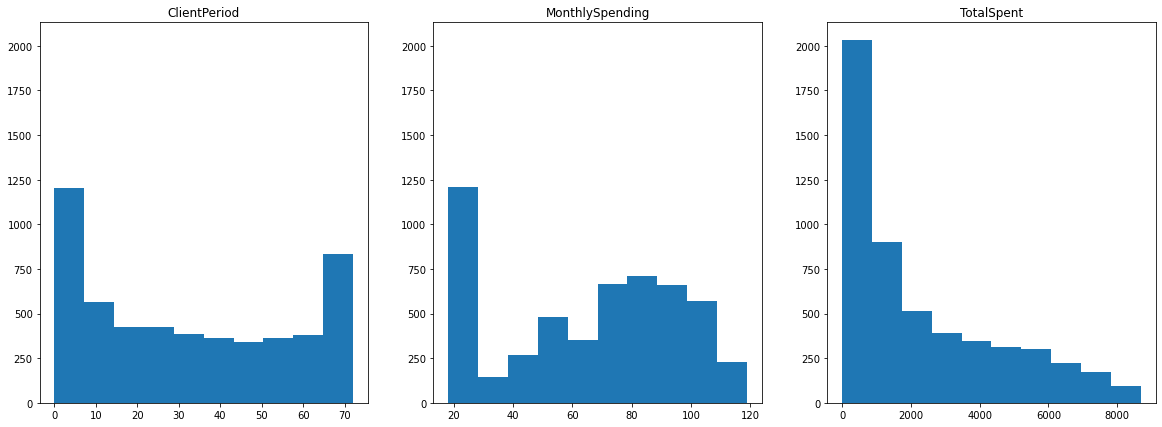

In [11]:
plt.figure(figsize=(20, 7))
ax = None
for i, column in enumerate(num_cols):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    ax.set_title(column)
    plt.hist(train[column])
plt.show()

### Категориальные фичи

In [12]:
out = list()
for column in cat_cols:
    out.append([column, train[column].nunique(), dict(train[column].value_counts())])
pd.DataFrame(out, columns=['column', 'num_uniq', 'count_uniq'])

,column,num_uniq,count_uniq
0,Sex,2,"{'Male': 2655, 'Female': 2627}"
1,IsSeniorCitizen,2,"{0: 4440, 1: 842}"
2,HasPartner,2,"{'No': 2705, 'Yes': 2577}"
3,HasChild,2,"{'No': 3676, 'Yes': 1606}"
4,HasPhoneService,2,"{'Yes': 4761, 'No': 521}"
5,HasMultiplePhoneNumbers,3,"{'No': 2511, 'Yes': 2250, 'No phone service': 521}"
6,HasInternetService,3,"{'Fiber optic': 2341, 'DSL': 1800, 'No': 1141}"
7,HasOnlineSecurityService,3,"{'No': 2612, 'Yes': 1529, 'No internet service': 1141}"
8,HasOnlineBackup,3,"{'No': 2332, 'Yes': 1809, 'No internet service': 1141}"
9,HasDeviceProtection,3,"{'No': 2317, 'Yes': 1824, 'No internet service': 1141}"


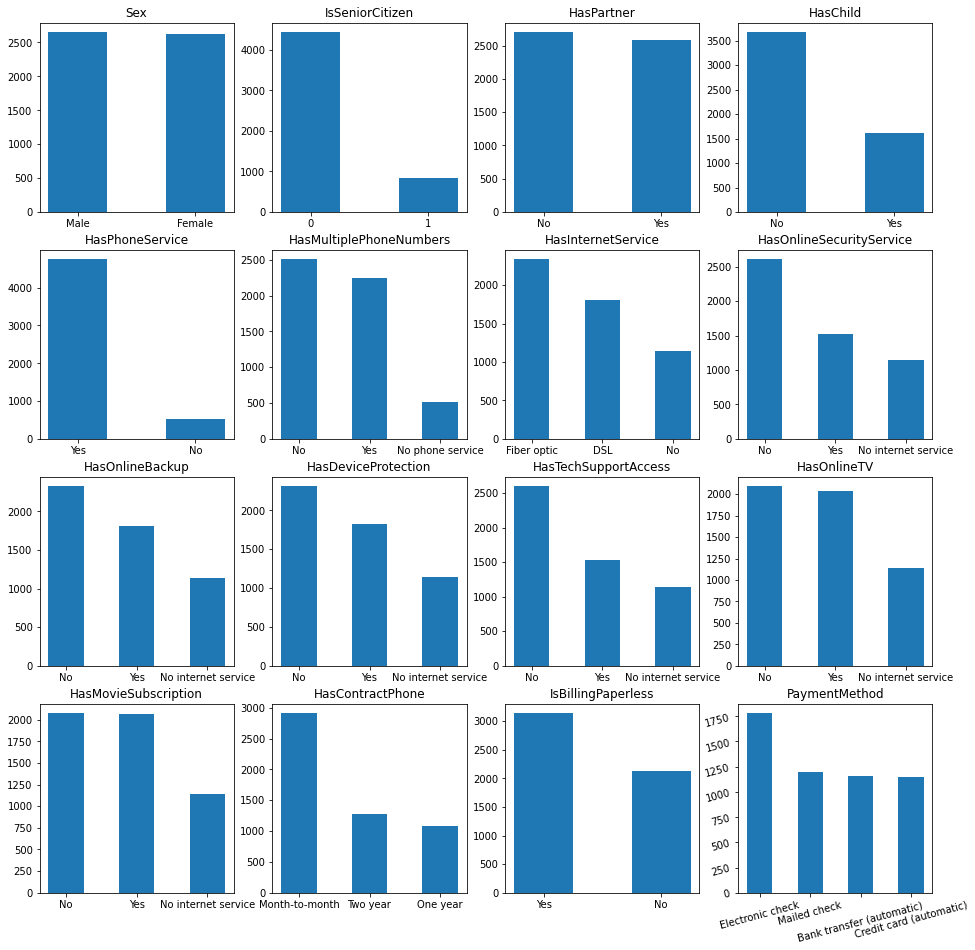

In [13]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
ax = ax.ravel()
for i, column in enumerate(cat_cols):
    serie = train[column].value_counts()
    labels = list(serie.index)
    values = list(serie)
    x = np.arange(len(labels))
    ax[i].set_title(column)
    ax[i].bar(x, values, width=0.5)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)
    if i == 15:
        ax[i].tick_params(labelrotation=15)

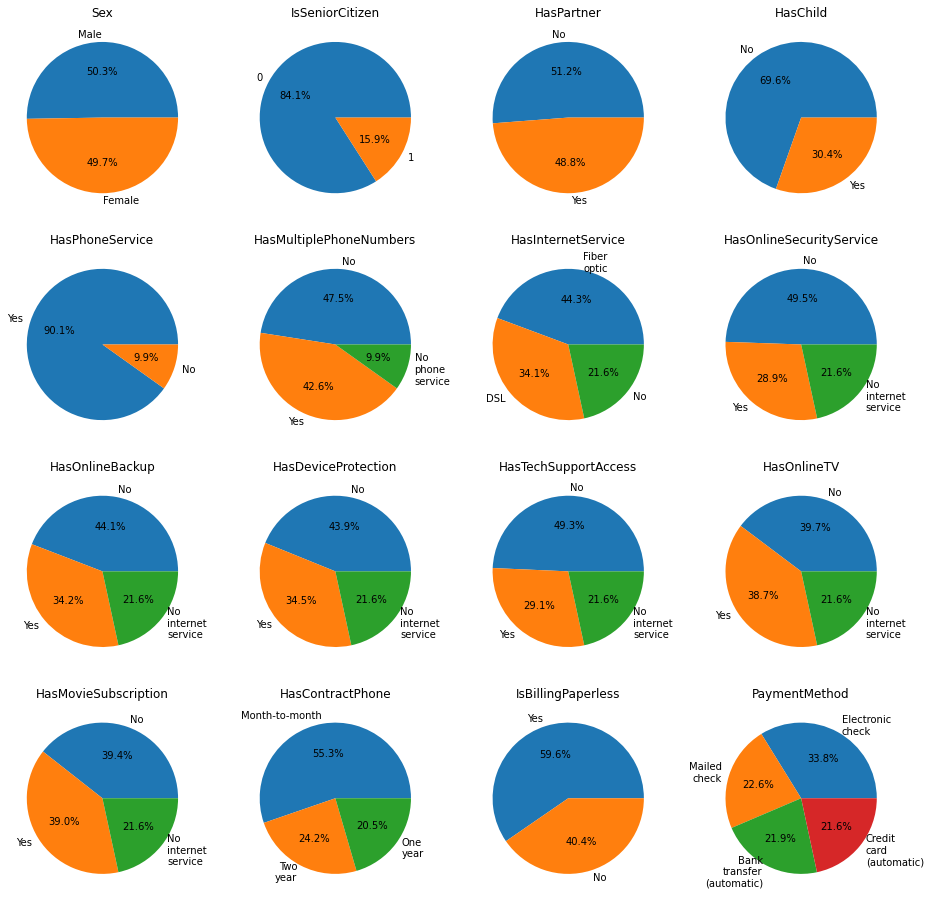

In [14]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
ax = ax.ravel()
for i, column in enumerate(cat_cols):
    serie = train[column].value_counts()
    labels = list(serie.index)
    values = list(serie)
    ax[i].set_title(column)
    ax[i].pie(values,
              labels=[str(s).replace(' ', '\n') for s in labels],
              autopct='%1.1f%%')

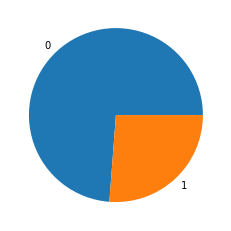

In [15]:
targets = train[target_col].value_counts()
plt.pie(
    targets,
    labels=list(targets.index)
)
plt.show()

Несбалансированных (сильно) классов нет

## Нормирование

In [16]:
cb_train = train.copy()
cb_test = test.copy()

In [17]:
y = train[target_col]

### Кодирование категориальных признаков

#### One-hot-encoder

In [18]:
dummy_data = pd.get_dummies(train[cat_cols], drop_first=True) # drop_first=True
train = pd.concat([train[num_cols], dummy_data], axis=1)

In [19]:
train[set(train.columns) - set(feature_cols)].head(5)

,HasOnlineTV_Yes,HasContractPhone_Two year,HasOnlineBackup_No internet service,IsBillingPaperless_Yes,HasInternetService_Fiber optic,HasPhoneService_Yes,HasOnlineSecurityService_Yes,HasMultiplePhoneNumbers_Yes,HasMovieSubscription_No internet service,HasOnlineBackup_Yes,...,HasOnlineTV_No internet service,PaymentMethod_Credit card (automatic),HasInternetService_No,HasTechSupportAccess_Yes,HasMovieSubscription_Yes,HasContractPhone_One year,Sex_Male,HasDeviceProtection_Yes,HasOnlineSecurityService_No internet service,HasChild_Yes
0,0,0,1,0,0,1,0,0,1,0,...,1,0,1,0,0,1,1,0,1,1
1,0,1,1,0,0,1,0,1,1,0,...,1,1,1,0,0,0,1,0,1,0
2,0,0,0,1,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,0,0,1,1,1,1,0,1,...,0,1,0,1,1,0,0,1,0,1


In [20]:
dummy_data = pd.get_dummies(test[cat_cols], drop_first=True) # drop_first=True
test = pd.concat([test[num_cols], dummy_data], axis=1)

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y, train_size=0.8, random_state=1)

### Нормирование числовых признаков

In [22]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])
train[num_cols] = scaler.transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


## Обучение моделей

In [23]:
X_train

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Male,HasPartner_Yes,HasChild_Yes,HasPhoneService_Yes,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,...,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
246,1.442176,1.435182,2.132938,0,1,0,0,1,0,1,...,0,1,0,1,1,0,0,0,1,0
3847,-0.066666,0.480628,0.037505,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,1,0,0
471,0.504247,1.163167,0.950690,0,0,0,0,1,0,0,...,0,1,0,1,1,0,1,0,1,0
1102,-1.126934,-0.689201,-0.921299,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
759,-1.290052,-0.490613,-0.995810,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0.422688,0.647508,0.582593,1,1,0,0,1,0,1,...,0,1,0,0,0,0,1,0,1,0
5192,-1.290052,0.140193,-0.987512,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3980,-0.352123,1.129791,0.049448,0,0,1,0,1,0,0,...,0,1,0,1,0,0,1,1,0,0
235,-0.433682,0.458934,-0.252898,0,0,1,0,1,0,1,...,0,1,0,1,0,0,1,0,1,0


In [24]:
models_params = {
    'logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 30, 50, 100],
        }
    },
    
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators' : [30, 50, 70, 100, 150, 200],
            'min_samples_split': [5, 10, 15, 20, 25, 30]
        }
    },
    
    'svm' : {
        'model': svm.SVC(gamma = 'auto'),
        'params': {
            'C': [1, 10, 20], 
            'kernel': ['rbf', 'linear']
        }
    },    
}

In [25]:
score_table = list()
for model_name, value in models_params.items():
    clf = GridSearchCV(
        value['model'],
        value['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=10,
    )
    clf.fit(train, y)
    print(clf.cv_results_['mean_test_score'])
    score_table.append({
        'model': model_name ,
        'best_score': clf.best_score_ ,
        'best_params': clf.best_params_,
        'best_model': clf.best_estimator_
    })

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    3.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.6s finished


[0.83289796 0.83912777 0.84372909 0.84494343        nan        nan
        nan 0.84512319]
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

[0.82136464 0.82550327 0.82611276 0.8289353  0.82798628 0.82979234
 0.83248012 0.83465817 0.83452024 0.8359223  0.83566062 0.8364547
 0.83547755 0.83653293 0.83736881 0.8378318  0.83947045 0.83910046
 0.83434663 0.84007009 0.83961334 0.83958495 0.84062542 0.84070084
 0.83930716 0.84031654 0.84059999 0.84068515 0.84127445 0.84192543
 0.83977067 0.84098625 0.84293219 0.842958   0.84280827 0.84235968]
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.824, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.854, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.850, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.832, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.830, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.829, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.856, total=   0.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.834, total=   0.1s
[CV] C=10 ............................................................
[CV] .................................. C=10, score=nan, total=   0.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.836, total=   0.1s
[CV] C

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s


[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.846, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.823, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.833, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.860, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.834, total=   0.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.856, total=   0.1s
[CV] C=10 ............................................................
[CV] .................................. C=10, score=nan, total=   0.1s
[CV] C

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   12.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.6s finished


[0.81858568 0.83433244 0.80341798 0.83441522 0.79962139 0.83451523]


In [26]:
pd.DataFrame(score_table, columns=['model', 'best_score', 'best_params'])

,model,best_score,best_params
0,logistic_regression,0.845123,{'C': 100}
1,random_forest,0.842958,"{'min_samples_split': 30, 'n_estimators': 100}"
2,svm,0.834515,"{'C': 20, 'kernel': 'linear'}"


In [27]:
y_pred = score_table[0]['best_model'].predict_proba(test)[:,-1]

### Градиентный бустинг

#### xgboost

In [28]:
import xgboost

In [29]:
params = {
#     'booster': ['gbtree'],
#     'n_estimators' : [8, 10, 12],
#     'eta': [0.07, 0.1, 0.12],
#     'max_depth': [7, 10, 12],
#     'min_child_weight': [6, 7, 8, 9],
#     'gamma': [0.03, 0.05, 0.07],
#     'colsample_bytree': [0.25, 0.3, 0.35],
    'booster': ['gblinear'],
    'n_estimators': [10000],
    'updater': ['shotgun']
}
clf = GridSearchCV(
    xgboost.XGBClassifier(),
    params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=10
)
clf.fit(train, y)
print(clf.cv_results_['mean_test_score'])
print(clf.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _

[08:04:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.8451232]
{'booster': 'gblinear', 'n_estimators': 10000, 'updater': 'shotgun'}


In [30]:
max(clf.cv_results_['mean_test_score'])

0.8451232033979081

Результаты предыдущих испытаний

In [31]:
pd.options.display.max_colwidth = 200
pd.DataFrame([
    [{'booster': 'gbtree', 'colsample_bytree': 0.35, 'eta': 0.07, 'gamma': 0.07, 'max_depth': 12, 'min_child_weight': 9, 'n_estimators': 10}, 0.8409537799837079],
    [{'colsample_bytree': 0.3, 'eta': 0.05, 'gamma': 0.0, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 10}, 0.8414464698372527],
    [{'colsample_bytree': 0.3, 'eta': 0.1, 'gamma': 0.05, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 10}, 0.842736281878973],
    [{'booster': 'gbtree', 'colsample_bytree': 0.35, 'eta': 0.12, 'gamma': 0.07, 'max_depth': 7, 'min_child_weight': 9, 'n_estimators': 10}, 0.8436879028707965],
    [{'booster': 'gblinear', 'eta': 0.15, 'lambda': 0, 'n_estimators': 500, 'updater': 'coord_descent'}, 0.844827631927552],
    [{'booster': 'gblinear', 'n_estimators': 500}, 0.8448524559481427],
    [{'booster': 'gblinear', 'n_estimators': 1000, 'updater': 'shotgun'}, 0.8449470472449274]
], columns=['best_params', 'mean_test_score'])

,best_params,mean_test_score
0,"{'booster': 'gbtree', 'colsample_bytree': 0.35, 'eta': 0.07, 'gamma': 0.07, 'max_depth': 12, 'min_child_weight': 9, 'n_estimators': 10}",0.840954
1,"{'colsample_bytree': 0.3, 'eta': 0.05, 'gamma': 0.0, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 10}",0.841446
2,"{'colsample_bytree': 0.3, 'eta': 0.1, 'gamma': 0.05, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 10}",0.842736
3,"{'booster': 'gbtree', 'colsample_bytree': 0.35, 'eta': 0.12, 'gamma': 0.07, 'max_depth': 7, 'min_child_weight': 9, 'n_estimators': 10}",0.843688
4,"{'booster': 'gblinear', 'eta': 0.15, 'lambda': 0, 'n_estimators': 500, 'updater': 'coord_descent'}",0.844828
5,"{'booster': 'gblinear', 'n_estimators': 500}",0.844852
6,"{'booster': 'gblinear', 'n_estimators': 1000, 'updater': 'shotgun'}",0.844947


In [32]:
y_pred = clf.best_estimator_.predict_proba(test)[:,-1]

#### catboost

In [33]:
import catboost

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(
    cb_train[feature_cols], y, train_size=0.8, random_state=1, stratify=y
)

In [35]:
boost_model = catboost.CatBoostClassifier(n_estimators=500, cat_features=cat_cols)
boost_model.fit(X_train, y_train)
y_train_pred = boost_model.predict_proba(X_train)[:, 1]
y_valid_pred = boost_model.predict_proba(X_valid)[:, 1]
roc_auc_score(y_train, y_train_pred), roc_auc_score(y_valid, y_valid_pred)

Learning rate set to 0.035992
0:	learn: 0.6692203	total: 64.1ms	remaining: 32s
1:	learn: 0.6490468	total: 74.5ms	remaining: 18.6s
2:	learn: 0.6289092	total: 85ms	remaining: 14.1s
3:	learn: 0.6106647	total: 95.7ms	remaining: 11.9s
4:	learn: 0.5943398	total: 106ms	remaining: 10.5s
5:	learn: 0.5800945	total: 116ms	remaining: 9.53s
6:	learn: 0.5665614	total: 123ms	remaining: 8.67s
7:	learn: 0.5560929	total: 127ms	remaining: 7.82s
8:	learn: 0.5452717	total: 135ms	remaining: 7.36s
9:	learn: 0.5360330	total: 144ms	remaining: 7.03s
10:	learn: 0.5267713	total: 154ms	remaining: 6.85s
11:	learn: 0.5175953	total: 163ms	remaining: 6.62s
12:	learn: 0.5099213	total: 172ms	remaining: 6.45s
13:	learn: 0.5030690	total: 179ms	remaining: 6.22s
14:	learn: 0.4960028	total: 189ms	remaining: 6.1s
15:	learn: 0.4892920	total: 202ms	remaining: 6.09s
16:	learn: 0.4832267	total: 211ms	remaining: 6s
17:	learn: 0.4798925	total: 215ms	remaining: 5.77s
18:	learn: 0.4751820	total: 226ms	remaining: 5.71s
19:	learn: 0.47

(0.8951667996474704, 0.8499097472924187)

In [36]:
# boost_model.fit(cb_train[feature_cols], y)

Пробуем подобрать

In [37]:
params = {
#     "learning_rate":[0.025, 0.03, 0.04],
#     "min_data_in_leaf":[88, 90, 92],
#     "depth": [3, 4, 5],
#     "iterations":[187, 190, 193]
# iter0
#     'learning_rate': [0.01, 0.05, 0.1],
#     'min_data_in_leaf': [10, 50, 100],
#     'depth': [3, 5, 10],
#     'iterations': [100, 200, 300]
# iter1
#     'learning_rate': [0.07, 0.1, 0.15],
#     'min_data_in_leaf': [5, 10, 20],
#     'depth': [4, 5, 7],
#     'iterations': [50, 100, 150]
# iter2
#     'learning_rate': [0.05, 0.1, 0.15],
#     'min_data_in_leaf': [10, 15, 20],
#     'depth': [4, 5, 6, 7],
#     'iterations': [100, 120, 150]
# iter3
    'learning_rate': [0.07, 0.1, 0.12],
    'min_data_in_leaf': [10, 12, 14],
    'depth': [5],
    'iterations': [110, 120, 130]
# iter4
#     'learning_rate': [0.08, 0.1, 0.12],
#     'min_data_in_leaf': [8, 9, 10, 12, 14],
#     'depth': [4, 5, 6],
#     'iterations': [100, 105, 110, 120, 130]

}
boost_model = catboost.CatBoostClassifier(cat_features=cat_cols, random_seed=1, verbose=False)
result = boost_model.grid_search(params, X_train, y_train)


bestTest = 0.4087138728
bestIteration = 109

0:	loss: 0.4087139	best: 0.4087139 (0)	total: 618ms	remaining: 16.1s

bestTest = 0.4091086554
bestIteration = 85

1:	loss: 0.4091087	best: 0.4087139 (0)	total: 1.33s	remaining: 16.6s

bestTest = 0.4100869148
bestIteration = 58

2:	loss: 0.4100869	best: 0.4087139 (0)	total: 1.94s	remaining: 15.6s

bestTest = 0.4086394265
bestIteration = 110

3:	loss: 0.4086394	best: 0.4086394 (3)	total: 2.51s	remaining: 14.4s

bestTest = 0.4091086554
bestIteration = 85

4:	loss: 0.4091087	best: 0.4086394 (3)	total: 3.1s	remaining: 13.7s

bestTest = 0.4100634663
bestIteration = 111

5:	loss: 0.4100635	best: 0.4086394 (3)	total: 3.68s	remaining: 12.9s

bestTest = 0.4086394265
bestIteration = 110

6:	loss: 0.4086394	best: 0.4086394 (3)	total: 4.29s	remaining: 12.3s

bestTest = 0.4091086554
bestIteration = 85

7:	loss: 0.4091087	best: 0.4086394 (3)	total: 4.9s	remaining: 11.6s

bestTest = 0.4100634663
bestIteration = 111

8:	loss: 0.4100635	best: 0.4086394 (3)	t

In [38]:
pd.DataFrame([[
    roc_auc_score(y_train, boost_model.predict_proba(X_train)[:, 1]),
    roc_auc_score(y_valid, boost_model.predict_proba(X_valid)[:, 1]),
    result['params'],
]])

,0,1,2
0,0.858785,0.854749,"{'min_data_in_leaf': 10, 'depth': 5, 'iterations': 120, 'learning_rate': 0.07}"


Некоторые старые результаты

In [39]:
pd.DataFrame([
    [0.859125, 0.855956, {'min_data_in_leaf': 10, 'depth': 5, 'iterations': 100, 'learning_rate': 0.1}],
    [0.85573, 0.855295, {'min_data_in_leaf': 5, 'depth': 4, 'iterations': 150, 'learning_rate': 0.07}],
    [0.859285, 0.856213, {'min_data_in_leaf': 10, 'depth': 5, 'iterations': 120, 'learning_rate': 0.1}],
    [0.859223, 0.856096, {'min_data_in_leaf': 10, 'depth': 5, 'iterations': 110, 'learning_rate': 0.1}],
    [0.859723, 0.856381, {'min_data_in_leaf': 8, 'depth': 6, 'iterations': 105, 'learning_rate': 0.08}],
])

,0,1,2
0,0.859125,0.855956,"{'min_data_in_leaf': 10, 'depth': 5, 'iterations': 100, 'learning_rate': 0.1}"
1,0.855730,0.855295,"{'min_data_in_leaf': 5, 'depth': 4, 'iterations': 150, 'learning_rate': 0.07}"
2,0.859285,0.856213,"{'min_data_in_leaf': 10, 'depth': 5, 'iterations': 120, 'learning_rate': 0.1}"
3,0.859223,0.856096,"{'min_data_in_leaf': 10, 'depth': 5, 'iterations': 110, 'learning_rate': 0.1}"
4,0.859723,0.856381,"{'min_data_in_leaf': 8, 'depth': 6, 'iterations': 105, 'learning_rate': 0.08}"


# Предсказания

#### catboost

In [40]:
y_pred = boost_model.predict_proba(cb_test)[:,-1]

In [41]:
submission = pd.read_csv(
    '/kaggle/input/advanced-dls-spring-2021/submission.csv',
    index_col='Id'
)
submission['Churn'] = y_pred
submission.to_csv('my_submission.csv')